In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import copy
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

In [3]:
dtrain = pd.read_csv("synthetic_train.csv").to_numpy().astype(np.float32)
dquery = pd.read_csv("synthetic_query.csv").to_numpy().astype(np.float32)
#dval = pd.read_csv("synthetic_val.csv").to_numpy().astype(np.float32)
dtest = pd.read_csv("synthetic_test.csv").to_numpy().astype(np.float32)

In [4]:
train_x, train_y = dtrain[:, 0:2], dtrain[:, 2:3]
#val_x, val_y = dval[:, 0:2], dval[:, 2:3]
query_x, query_y = dquery[:, 0:2], dquery[:, 2:3]
test_x, test_y = dtest[:, 0:2], dtest[:, 2:3]

In [24]:
print(train_x.min(0), train_x.max(0))
print(query_x.min(0), query_x.max(0))

[0. 0.] [1. 1.]
[ 0.00178321 -0.00011653] [1.0002748  0.99884534]


In [5]:
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
#val_x = scaler.transform(val_x)
query_x = scaler.transform(query_x)
test_x = scaler.transform(test_x)

In [6]:
Train = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
#Val = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
Test = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

In [7]:
train_loader = DataLoader(Train, batch_size  = 128)
#val_loader = DataLoader(Val, batch_size = 128)
test_loader = DataLoader(Test, batch_size = 128)

In [8]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    model.train()
    prediction = []
    label = []

    for batch_idx, (data, target) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.round(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        label.extend(target.tolist())
        prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    model.eval()
    prediction = []
    label = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(iterator):

            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            preds = torch.round(output)
            loss = criterion(output, target)
            epoch_loss += loss.item() * len(target)
            label.extend(target.tolist())
            prediction.extend(preds.reshape(-1).tolist())
            
    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1


In [9]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = model.to(device)
criterion = criterion.to(device)

best_f1 = -float('inf')
best_model = None
best_acc = -float('inf')

for epoch in range(100):

    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, val_f1 = evaluate(model, test_loader, criterion, device)

#     if val_f1 > best_f1:
#         best_f1 = val_f1
#         best_model = copy.deepcopy(model)
#         best_acc = valid_acc

    print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
    print(f'Epoch: {epoch} | Val. Loss: {valid_loss:.4f} |  Val. Acc: {valid_acc:.4f} |  Val. F1: {val_f1:.4f}')

print("Best Val. F1: {:.4f}, Best Val. Accuarcy: {:.4f}".format(best_f1, best_acc))

Epoch: 0 | Train Loss: 0.6812 | Train Acc: 0.5587 | Train F1: 0.7094
Epoch: 0 | Val. Loss: 0.6823 |  Val. Acc: 0.5253 |  Val. F1: 0.6810
Epoch: 1 | Train Loss: 0.6773 | Train Acc: 0.5607 | Train F1: 0.7103
Epoch: 1 | Val. Loss: 0.6781 |  Val. Acc: 0.5293 |  Val. F1: 0.6828
Epoch: 2 | Train Loss: 0.6732 | Train Acc: 0.5667 | Train F1: 0.7132
Epoch: 2 | Val. Loss: 0.6735 |  Val. Acc: 0.5373 |  Val. F1: 0.6865
Epoch: 3 | Train Loss: 0.6687 | Train Acc: 0.5733 | Train F1: 0.7163
Epoch: 3 | Val. Loss: 0.6685 |  Val. Acc: 0.5520 |  Val. F1: 0.6934
Epoch: 4 | Train Loss: 0.6638 | Train Acc: 0.5887 | Train F1: 0.7237
Epoch: 4 | Val. Loss: 0.6630 |  Val. Acc: 0.5840 |  Val. F1: 0.7090
Epoch: 5 | Train Loss: 0.6582 | Train Acc: 0.6020 | Train F1: 0.7302
Epoch: 5 | Val. Loss: 0.6567 |  Val. Acc: 0.6053 |  Val. F1: 0.7197
Epoch: 6 | Train Loss: 0.6519 | Train Acc: 0.6233 | Train F1: 0.7409
Epoch: 6 | Val. Loss: 0.6497 |  Val. Acc: 0.6387 |  Val. F1: 0.7371
Epoch: 7 | Train Loss: 0.6449 | Train Acc

Epoch: 63 | Train Loss: 0.2360 | Train Acc: 0.9887 | Train F1: 0.9896
Epoch: 63 | Val. Loss: 0.2263 |  Val. Acc: 0.9947 |  Val. F1: 0.9948
Epoch: 64 | Train Loss: 0.2325 | Train Acc: 0.9893 | Train F1: 0.9902
Epoch: 64 | Val. Loss: 0.2229 |  Val. Acc: 0.9947 |  Val. F1: 0.9948
Epoch: 65 | Train Loss: 0.2291 | Train Acc: 0.9907 | Train F1: 0.9914
Epoch: 65 | Val. Loss: 0.2195 |  Val. Acc: 0.9947 |  Val. F1: 0.9948
Epoch: 66 | Train Loss: 0.2258 | Train Acc: 0.9907 | Train F1: 0.9914
Epoch: 66 | Val. Loss: 0.2163 |  Val. Acc: 0.9960 |  Val. F1: 0.9961
Epoch: 67 | Train Loss: 0.2226 | Train Acc: 0.9907 | Train F1: 0.9914
Epoch: 67 | Val. Loss: 0.2131 |  Val. Acc: 0.9960 |  Val. F1: 0.9961
Epoch: 68 | Train Loss: 0.2195 | Train Acc: 0.9907 | Train F1: 0.9914
Epoch: 68 | Val. Loss: 0.2100 |  Val. Acc: 0.9960 |  Val. F1: 0.9961
Epoch: 69 | Train Loss: 0.2165 | Train Acc: 0.9907 | Train F1: 0.9914
Epoch: 69 | Val. Loss: 0.2070 |  Val. Acc: 0.9960 |  Val. F1: 0.9961
Epoch: 70 | Train Loss: 0.2

In [9]:
# torch.save(model, "synthetic.pt")

In [18]:
XX_query = torch.from_numpy(query_x)
#XX_val = torch.from_numpy(val_x)
XX_test = torch.from_numpy(test_x)

In [19]:
model.eval()

with torch.no_grad():
    yy_query_p = torch.round(model(XX_query)).numpy()
    #yy_val_p = torch.round(model(XX_val)).numpy()
    yy_test_p = torch.round(model(XX_test)).numpy()


In [20]:
ddquery = np.concatenate((dquery[:, 0:2], yy_query_p), axis = 1)
#ddval = np.concatenate((dval[:, 0:2], yy_val_p), axis = 1)
ddtest = np.concatenate((dtest[:, 0:2], yy_test_p), axis = 1)

In [13]:
# np.save("synthetic_query_v1.npy", ddquery)
# #np.save("synthetic_val_v1.npy", ddval)
# np.save("synthetic_test_v1.npy", ddtest)

In [14]:
h= 0.02
x_min, x_max = dquery[:, 0].min() - .5, dquery[:, 0].max() + .5
y_min, y_max = dquery[:, 1].min() - .5, dquery[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

dplot = np.c_[xx.ravel(), yy.ravel()]
_dplot = scaler.transform(dplot).astype(np.float32)
_dplot = torch.from_numpy(_dplot)
S = torch.round(model(_dplot)).detach().numpy()
S = S.reshape(xx.shape)

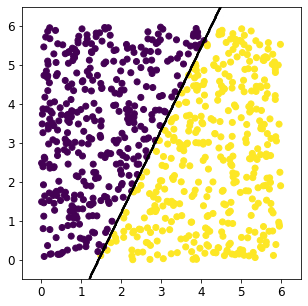

In [23]:
import matplotlib
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=12)
fig.set_size_inches(5, 5)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
SS = S.round()
CS = ax.contour(xx, yy, SS, colors = "black")
ax.scatter(dtest[:, 0], dtest[:, 1], c = yy_test_p)
plt.show()